In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
from itertools import product
import os, pickle
import pickle, json, os
from datetime import datetime

plt.style.use("seaborn-v0_8")

In [2]:
df = pd.read_csv(r"E:\data\stock_prices.csv",index_col="date",parse_dates=True)
df = df.sort_index()
print("Loaded real data:", df.shape)

Loaded real data: (1950, 10)


In [3]:
SEQ = 5   # window length (30 days history)

def make_sequence_windows(X, seq_len):
    X = np.asarray(X)
    T = X.shape[0]
    out = []
    for i in range(T - seq_len):
        out.append(X[i:i+seq_len])
    return np.stack(out, axis=0)   # (N_seq, SEQ, D)

In [4]:
# ================================================================
# 1. Feature Builder (same as training)
# ================================================================
def compute_returns(px_df, kind="log"):
    return (np.log(px_df).diff() if kind=="log" else px_df.pct_change()).dropna()

def realized_vol(ret_df, window=20):
    return ret_df.rolling(window, min_periods=window).std()

def add_time_lags_df(df_in, lags=5, name_suffix=""):
    parts = [df_in.shift(k).add_suffix(f"{name_suffix}_t-{k}") for k in range(1, lags+1)]
    return pd.concat(parts, axis=1)

def build_features_target_next_price(px_df, lags=5, vol_windows=(5,20), include_level=True):
    ret = compute_returns(px_df, "log")
    px_aligned = px_df.loc[ret.index]

    X_ret = add_time_lags_df(ret, lags=lags, name_suffix="_r")
    X_vol = pd.concat([
        add_time_lags_df(realized_vol(ret,w), lags=min(3,lags), name_suffix=f"_vol{w}")
        for w in vol_windows
    ], axis=1)

    # volatility regime (3 binary indicators)
    mkt_vol = realized_vol(ret, window=vol_windows[0]).median(axis=1)
    q = mkt_vol.quantile([0.33,0.66])

    X_reg = pd.concat([
        (mkt_vol <= q.iloc[0]).astype(int).rename("reg_low"),
        ((mkt_vol>q.iloc[0])&(mkt_vol<=q.iloc[1])).astype(int).rename("reg_mid"),
        (mkt_vol>q.iloc[1]).astype(int).rename("reg_high")
    ], axis=1)

    parts = [X_ret, X_vol, X_reg]

    if include_level:
        X_lvl = add_time_lags_df(px_aligned - px_aligned.mean(), lags=min(2,lags), name_suffix="_lvl")
        parts.append(X_lvl)

    X = pd.concat(parts, axis=1).dropna()
    Y_next = px_aligned.shift(-1).reindex(X.index).dropna()
    X = X.loc[Y_next.index]

    return X, Y_next

In [ ]:
# ============================================================
# 5) ESN CLASS 
# ============================================================
class EchoStateNetworkSingle:
    def __init__(self, n_inputs, n_outputs, 
                 n_res_fast=180,n_res_slow=100,
                 sr_fast=0.95, sr_slow=0.75,
                 sparsity=0.9, leak_fast=0.3, leak_slow=0.15,
                 input_scaling=1.0, add_input_to_readout=True,
                 noise=0.0, ridge_alpha=1e-2, random_state=42):
        
        self.n_inputs, self.n_outputs=n_inputs, n_outputs
        self.add_input_to_readout = add_input_to_readout
        self.ridge_alpha, self.noise = ridge_alpha, noise
        self.rng = np.random.RandomState(random_state)

        def init_res(n_res, sr, leak):
            Win = (self.rng.rand(n_res, n_inputs) - 0.5) *2.0 * input_scaling
            W = self.rng.rand(n_res, n_res) -0.5
            W[self.rng.rand(n_res, n_res)<sparsity] = 0.0
            eigmax = np.max(np.abs(np.linalg.eigvals(W))) or 1e-6
            return Win, (W/eigmax)*sr, leak
        
        self.Win_f, self.W_f, self.leak_f = init_res(n_res_fast, sr_fast, leak_fast)
        self.Win_s, self.W_s, self.leak_s = init_res(n_res_slow, sr_slow, leak_slow)

        self.readout = Ridge(alpha=self.ridge_alpha, fit_intercept=False)

    def _run(self, X):
        T=X.shape[0]
        xf = np.zeros(self.Win_f.shape[0])
        xs = np.zeros(self.Win_s.shape[0])
        states = np.zeros((T, xf.size + xs.size))

        for t in range(T):
            xf = (1-self.leak_f)*xf + self.leak_f *np.tanh(self.Win_f @ X[t] + self.W_f @ xf)
            xs = (1-self.leak_s)*xs + self.leak_s *np.tanh(self.Win_s @ X[t] + self.W_s @ xs)

            if self.noise:
                xf += self.noise * self.rng.randn(*xf.shape)
                xs += self.noise * self.rng.randn(*xs.shape)

                states[t] = np.concatenate([xf, xs])

            return states
    # FIT on SEQUENCES
    def fit_sequence(self, X_seq, Y_seq):
        # X_seq: (N_seq, SEQ, D) Y_seq: (N_seq, 1)
        feats = []          
        
        for i in range(len(X_seq)):
            S=self._run(X_seq[i])
            last_state = S[-1]

            parts = [last_state]
            if self.add_input_to_readout:
                parts.append(X_seq[i, -1]) # last input vector
            feats.append(np.ones(1))  # bias

            feats.append(np.concatenate(parts))
      
        Phi = np.vstack(feats)
        self.readout.fit(Phi, Y_seq)

        # PREDICT on SEQUENCES
    def predict_sequence(self, X_seq):
        feats = []

        for i in range(len(X_seq)):
            S=self._run(X_seq[i])
            last_state = S[-1]

            parts = [last_state]
            if self.add_input_to_readout:
                parts.append(X_seq[i, -1])
            parts.append(np.ones(1))

            feats.append(np.concatenate(parts))

            Phi = np.vstack(feats)
        return self.readout.predict(Phi)

Shapes: X_train=(1348, 193), X_val=(289, 193), X_test=(289, 193)
Targets: Y_train=(1348, 10), Y_val=(289, 10), Y_test=(289, 10)
Sequence X_trv_seq: (1632, 5, 193)
Sequence X_te_seq : (284, 5, 193)

=== MODEL 1 — SEQUENCE ESN per-asset / LAGS=11 / SEQ=5 ===
RMSE overall: 11.367
MAE  overall: 7.487
R²   overall: 0.995


,RMSE,MAE,R²
SCHD,0.698,0.527,0.247
VZ,1.359,1.086,0.523
PG,4.862,3.933,0.280
XOM,8.154,6.896,-1.960
CVX,8.361,6.537,-0.002
AMZN,9.439,7.353,0.755
VOO,11.505,8.521,0.876
MSFT,13.953,10.677,0.906
CAT,16.983,13.273,0.838
AVGO,20.616,16.068,0.867


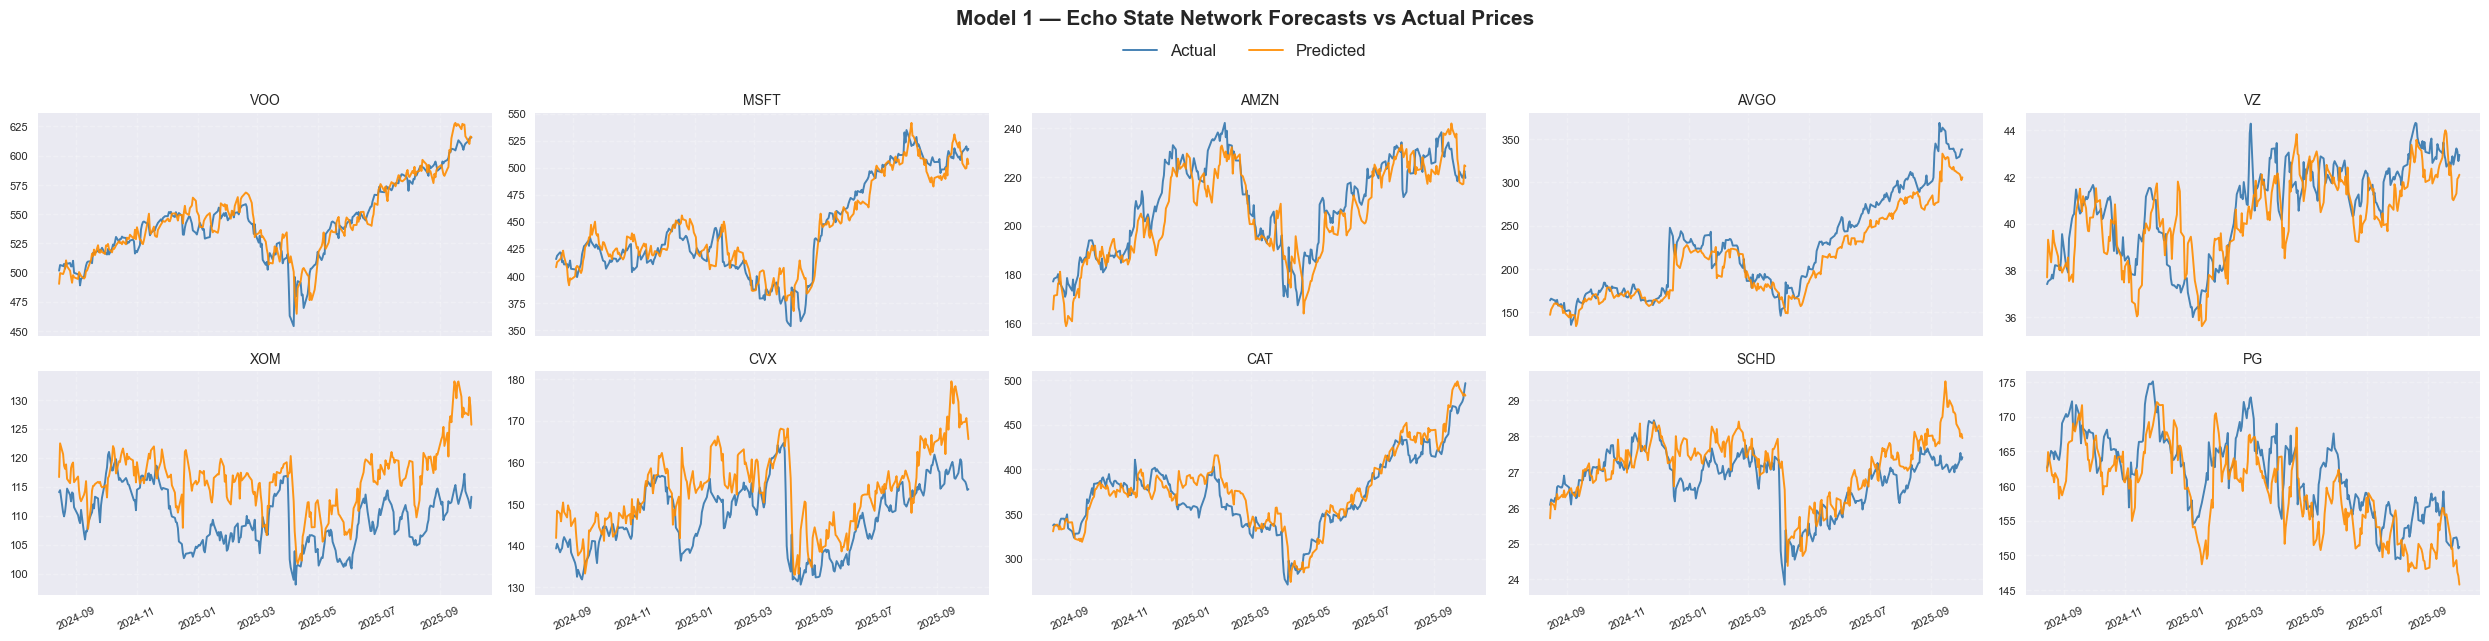

In [ ]:
# ============================================================
# 3) BUILD DATASET (use fixed optimal LAGS)
# ============================================================
LAGS = 11 
X_df, Y_df = build_features_target_next_price(df, lags=LAGS)

n = len(X_df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X_df.iloc[:train_end]
X_val   = X_df.iloc[train_end:val_end]
X_test  = X_df.iloc[val_end:]

Y_train = Y_df.iloc[:train_end]
Y_val   = Y_df.iloc[train_end:val_end]
Y_test  = Y_df.iloc[val_end:]

assets   = Y_df.columns.tolist()
idx_test = X_test.index

print(f"Shapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
print(f"Targets: Y_train={Y_train.shape}, Y_val={Y_val.shape}, Y_test={Y_test.shape}")


# ============================================================
# 4) SCALING (fit only on train)
# ============================================================
scX = StandardScaler().fit(X_train)
scY = StandardScaler().fit(Y_train)

X_trv = scX.transform(pd.concat([X_train, X_val]))
Y_trv = scY.transform(pd.concat([Y_train, Y_val]))

X_te  = scX.transform(X_test)
Y_te  = scY.transform(Y_test)


# ============================================================
# 5) Convert to SEQUENCE windows
# ============================================================
SEQ = 5 

X_trv_seq = make_sequence_windows(X_trv, SEQ)
Y_trv_seq = Y_trv[SEQ:]              # align target with sequences

X_te_seq  = make_sequence_windows(X_te, SEQ)
Y_te_seq  = Y_test.values[SEQ:]      # true prices aligned

print("Sequence X_trv_seq:", X_trv_seq.shape)
print("Sequence X_te_seq :", X_te_seq.shape)


# ============================================================
# 6) TRAIN PER ASSET + PREDICT TEST
# ============================================================
models = {}
pred_cols = []

for j, a in enumerate(assets):

    esn = EchoStateNetworkSingle(
        n_inputs=X_trv_seq.shape[2],
        n_outputs=1,
        random_state=42
    )

    esn.fit_sequence(X_trv_seq, Y_trv_seq[:, [j]])

    yhat_sc = esn.predict_sequence(X_te_seq)

    # -------------------------------
    # FIX: ensure column shape (N,1)
    # -------------------------------
    if yhat_sc.ndim == 1:
        yhat_sc = yhat_sc.reshape(-1, 1)

    pred_cols.append(yhat_sc)
    models[a] = esn

Y_hat_sc = np.hstack(pred_cols)
Y_hat = scY.inverse_transform(Y_hat_sc)



# ============================================================
# 7) METRICS
# ============================================================
Y_true_seq = Y_te_seq          # (284, 10)
idx_test_seq = idx_test[SEQ:]  # (284,)
Y_hat = Y_hat                   # sequence predictions (284, 10)
# Correct Y_true for sequence model
Y_true = Y_te_seq

rmse_overall = np.sqrt(mean_squared_error(Y_true.flatten(), Y_hat.flatten()))
mae_overall  = mean_absolute_error(Y_true.flatten(), Y_hat.flatten())
r2_overall   = r2_score(Y_true.flatten(), Y_hat.flatten())

print(f"\n=== MODEL 1 — SEQUENCE ESN per-asset / LAGS={LAGS} / SEQ={SEQ} ===")
print(f"RMSE overall: {rmse_overall:.3f}")
print(f"MAE  overall: {mae_overall:.3f}")
print(f"R²   overall: {r2_overall:.3f}")

rmse_vec = np.sqrt(((Y_true - Y_hat) ** 2).mean(axis=0))
mae_vec  = np.abs(Y_true - Y_hat).mean(axis=0)
r2_vec   = [r2_score(Y_true[:, i], Y_hat[:, i]) for i in range(len(assets))]

metrics_df = pd.DataFrame(
    {"RMSE": rmse_vec, "MAE": mae_vec, "R²": r2_vec},
    index=assets
).sort_values("RMSE")


display(metrics_df.style.background_gradient(cmap="coolwarm", axis=0).format("{:.3f}"))

# ============================================================
# === 8) PLOTS 
# ============================================================
n_assets = len(assets)
ncols = 5
nrows = math.ceil(n_assets / ncols)

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5*ncols, 3.2*nrows),
    sharex=True
)
axes = np.ravel(axes)

for i, a in enumerate(assets):
    ax = axes[i]
    ax.plot(idx_test_seq, Y_true_seq[:, i],lw=1.4, color="steelblue", label="Actual")
    ax.plot(idx_test_seq, Y_hat[:, i],lw=1.4, color="darkorange", alpha=0.9, label="Predicted")
    ax.set_title(f"{a}", fontsize=10)
    ax.grid(True, alpha=0.25, linestyle="--")
    ax.tick_params(axis="x", rotation=25, labelsize=8)
    ax.tick_params(axis="y", labelsize=8)

# remove blank panels
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# CLEAN GLOBAL LEGEND
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,loc="upper center",bbox_to_anchor=(0.5, 0.965),ncol=2,frameon=False,fontsize=12)
fig.suptitle("Model 1 — Echo State Network Forecasts vs Actual Prices",fontsize=15,fontweight="bold",y=0.995)
plt.tight_layout(rect=(0, 0, 1, 0.94))
plt.show()

In [ ]:
# =====================================================================
# MODEL 1 - PER-ASSET ESN (SEQUENCE MODE) : DETAILED INPUT REPORT
# =====================================================================

print("\n================ MODEL 1 — PER-ASSET ESN (SEQUENCE) ================")

# ---------------------------------------------------------------------
# DATASET SPLIT
# ---------------------------------------------------------------------
print("\n--- Dataset split (days) ---")
print("Train days :", X_train.shape[0])
print("Val days   :", X_val.shape[0])
print("Test days  :", X_test.shape[0])
print("Assets     :", Y_df.shape[1])

# ---------------------------------------------------------------------
# FEATURE ENGINEERING - INPUT COMPONENTS
# ---------------------------------------------------------------------
print("\n--- Feature engineering components (per timestep Z_t) ---")
print("Return lags (log-returns)       :", Y_df.shape[1] * LAGS)
print("Volatility lags (vol5, vol20)   :", Y_df.shape[1] * min(3, LAGS) * 2)
print("Volatility regime dummies       :", 3, "(low / mid / high)")
print("Price level lags                :", Y_df.shape[1] * min(2, LAGS))

print("---------------------------------------------------------")
print("TOTAL engineered features Z_t   :", X_df.shape[1])

# ---------------------------------------------------------------------
# RAW FEATURE MATRIX
# ---------------------------------------------------------------------
print("\n--- Raw feature matrix ---")
print("X_trv shape (time, Z_t)         :", X_trv.shape)
print("X_te  shape (time, Z_t)         :", X_te.shape)
print("Feature dimension Z_t           :", X_trv.shape[1])

# ---------------------------------------------------------------------
# SEQUENCE WINDOW CONSTRUCTION
# ---------------------------------------------------------------------
print("\n--- Sequence window construction ---")
print("Sequence length (SEQ)           :", SEQ)
print("X_trv_seq shape (N,SEQ,Z_t)     :", X_trv_seq.shape)
print("X_te_seq  shape (N,SEQ,Z_t)     :", X_te_seq.shape)

# ---------------------------------------------------------------------
# ESN INPUT (PER-ASSET)
# ---------------------------------------------------------------------
print("\n--- ESN input structure (per asset) ---")
print("Input per timestep Z_t dim      :", X_trv_seq.shape[2])
print("Sequence window length          :", X_trv_seq.shape[1])
print("ESN input tensor                :", X_trv_seq.shape)

# ---------------------------------------------------------------------
# TARGET STRUCTURE
# ---------------------------------------------------------------------
print("\n--- Targets ---")
print("Y_trv_seq shape (N,assets)      :", Y_trv_seq.shape)
print("Y_te_seq  shape (N,assets)      :", Y_te_seq.shape)
print("Output dimension (assets)       :", Y_trv_seq.shape[1])

# ---------------------------------------------------------------------
# MODEL I/O SUMMARY
# ---------------------------------------------------------------------
print("\n--- Final model I/O summary ---")
print("Model input  : sequence of shape (SEQ, Z_t)")
print("Model output : next-day price per asset")

print("\n===============================================================")


================ MODEL 1 — PER-ASSET ESN (SEQUENCE) ================

--- Dataset split (days) ---
Train days : 1348
Val days   : 289
Test days  : 289
Assets     : 10

--- Feature engineering components (per timestep Z_t) ---
Return lags (log-returns)       : 110
Volatility lags (vol5, vol20)   : 60
Volatility regime dummies       : 3 (low / mid / high)
Price level lags                : 20
---------------------------------------------------------
TOTAL engineered features Z_t   : 193

--- Raw feature matrix ---
X_trv shape (time, Z_t)         : (1637, 193)
X_te  shape (time, Z_t)         : (289, 193)
Feature dimension Z_t           : 193

--- Sequence window construction ---
Sequence length (SEQ)           : 5
X_trv_seq shape (N,SEQ,Z_t)     : (1632, 5, 193)
X_te_seq  shape (N,SEQ,Z_t)     : (284, 5, 193)

--- ESN input structure (per asset) ---
Input per timestep Z_t dim      : 193
Sequence window length          : 5
ESN input tensor                : (1632, 5, 193)

--- Targets ---
Y

In [ ]:
import time

start_time = time.time()

models = {}
pred_cols = []

for j, a in enumerate(assets):

    esn = EchoStateNetworkSingle(
        n_inputs=X_trv_seq.shape[2],
        n_outputs=1,
        random_state=42
    )

    esn.fit_sequence(X_trv_seq, Y_trv_seq[:, [j]])

    yhat_sc = esn.predict_sequence(X_te_seq)

    if yhat_sc.ndim == 1:
        yhat_sc = yhat_sc.reshape(-1, 1)

    pred_cols.append(yhat_sc)
    models[a] = esn

end_time = time.time()

print(f"\nTotal training time (all assets): {end_time - start_time:.2f} seconds")
params_per_model = models[assets[0]].readout.coef_.size
print("Trainable parameters per asset:", params_per_model)

total_params = sum(m.readout.coef_.size for m in models.values())
print("Total trainable parameters (all ESNs):", total_params)

def esn_size_mb(model):
    size = 0
    
    size += model.Win_f.nbytes
    size += model.W_f.nbytes
    size += model.Win_s.nbytes
    size += model.W_s.nbytes
    
    if hasattr(model.readout, "coef_"):
        size += model.readout.coef_.nbytes
        
    return size / 1024**2

sizes = [esn_size_mb(m) for m in models.values()]
print(f"Average ESN size: {np.mean(sizes):.2f} MB")
print(f"Total ESN memory footprint: {np.sum(sizes):.2f} MB")


Total training time (all assets): 3.30 seconds
Trainable parameters per asset: 474
Total trainable parameters (all ESNs): 4740
Average ESN size: 0.74 MB
Total ESN memory footprint: 7.39 MB


### Model 1 save

In [ ]:
#SAVE_DIR = r"C:\models\ESN_Model1"
os.makedirs(SAVE_DIR, exist_ok=True)

bundle = {
    "models": models,        
    "scX": scX,
    "scY": scY,

    # --- structure ---
    "assets": assets,
    "X_columns": X_df.columns.tolist(),
    "LAGS": LAGS,
    "SEQ": SEQ,

    # --- splits ---
    "train_end": train_end,
    "val_end": val_end,

    # --- outputs (CRITICAL for Markowitz) ---
    "Y_hat_test": Y_hat,            # (T_test_seq, N_assets)
    "Y_true_test": Y_true_seq,

    # --- metadata ---
    "seed": 42,
    "created_at": str(datetime.now()),
    "model_type": "ESN per-asset sequence",
    "notes": "Model1 — per-asset ESN with sequence windows"
}

with open(os.path.join(SAVE_DIR, "ESN_Model1_bundle.pkl"), "wb") as f:
    pickle.dump(bundle, f)

print("Model1 saved in research-grade format")

✓ Model1 saved in research-grade format
